In [19]:
import numpy as np
import cv2
import pandas as pd
import PIL
import utm
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib as mpl
import os

In [20]:
def start_end_point(lat, lon):
    start = [lon - 55, lat + 50]
    end = [lon + 55, lat - 50]
    if start[0] > 180:
        start[0] = start[0] - 360
    elif start[0] < -180:
        start[0] = start[0] + 360
    if start[1] > 80:
        start[1] = start[1] - 160
    elif start[1] < - 80:
        start[1] = start[1] + 160

    if end[0] > 180:
        end[0] = end[0] - 360
    elif end[0] < -180:
        end[0] = end[0] + 360
    if end[1] > 80:
        end[1] = end[1] - 160
    elif end[1] < - 80:
        end[1] = end[1] + 160

    return(start, end)

def conv_func(data): # dont do this, ever, this is very bad. Will need to rewrite it for sure. NEED TO RE DO THIS FOR SURE

    starting_points = []
    ending_points = []

    for i in range(len(data)):
        start, end = start_end_point(data.iloc[i]['latitude'], data.iloc[i]['longitude'])
        
        start_utm = utm.from_latlon(start[1], start[0])
        starting_points.append(start_utm[2:])
        
        end_utm = utm.from_latlon(end[1], end[0])
        ending_points.append(end_utm[2:])

    starting_zones = pd.DataFrame(starting_points)
    ending_zones = pd.DataFrame(ending_points)

    coords = pd.concat([data, starting_zones, ending_zones],axis=1)
    coords.columns = ['latitude', 'longitude', 's_zone', 's_band', 'e_zone', 'e_band']

    coords['ns_band'] = [ ord(x) - 64 for x in coords.s_band ]
    coords['ne_band'] = [ ord(x) - 64 for x in coords.e_band ]

    bins_zone = [i*15 for i in range(0,5)]
    labels_zone = [i for i in range(1,5)]

    bins_band = [i*6 for i in range(0,5)]
    labels_band = [i for i in range(1,5)]

    # Binning results
    coords['s_bin_zone'] = pd.DataFrame(pd.cut(coords['s_zone'], bins=bins_zone, labels=labels_zone))
    coords['s_bin_band'] = pd.DataFrame(pd.cut(coords['ns_band'], bins=bins_band, labels=labels_band))
    coords['e_bin_zone'] = pd.DataFrame(pd.cut(coords['e_zone'], bins=bins_zone, labels=labels_zone))
    coords['e_bin_band'] = pd.DataFrame(pd.cut(coords['ne_band'], bins=bins_band, labels=labels_band))

    return coords

Currently, the code below only makes dataset for a single video, but thats only because If we made it for all videos, it would take a long time to process. Figuring out a nice way to store the data is work in progress

In [21]:
subject_list = [f for f in os.listdir('./data/head_tracking_data') if 'Subject' in f] # list of all subjects
video_list = [f for f in os.listdir('./data/video_files') if 'mp4' in f] # list of all videos


videos = {} # each video will contain all subjects

frames_per_segment = 30
video_id = video_list[19]
# for video_id in video_list[19]:  # << thats the part that did for all videos
subjects = {} # for each subject, we store segments which are in seperate lists

for subject_id in subject_list:
    tmp_data = pd.read_fwf('data/head_tracking_data/'+ subject_id + '/' + video_id.split('.mp4')[0] + '.txt', header=None)
    tmp_data.columns = ['latitude', 'longitude']
    processed_data = conv_func(tmp_data)
    n_segments = int(len(tmp_data)/frames_per_segment) # ofc its not entirely coorect yet, it approximates how many segments\
    segments = []

    for seg in range(n_segments):
        start = frames_per_segment * seg
        end = frames_per_segment * (seg+1)
        segments.append(processed_data[start:end])

    subjects[subject_id] = segments

videos[video_id] = subjects

In [22]:
print(videos.keys())
print(videos[next(iter(videos))].keys())

dict_keys(['Help.mp4'])
dict_keys(['Subject_1', 'Subject_10', 'Subject_11', 'Subject_12', 'Subject_13', 'Subject_14', 'Subject_15', 'Subject_16', 'Subject_17', 'Subject_18', 'Subject_19', 'Subject_2', 'Subject_20', 'Subject_21', 'Subject_22', 'Subject_23', 'Subject_24', 'Subject_25', 'Subject_26', 'Subject_27', 'Subject_28', 'Subject_29', 'Subject_3', 'Subject_30', 'Subject_31', 'Subject_32', 'Subject_33', 'Subject_34', 'Subject_35', 'Subject_36', 'Subject_37', 'Subject_38', 'Subject_39', 'Subject_4', 'Subject_40', 'Subject_5', 'Subject_6', 'Subject_7', 'Subject_8', 'Subject_9'])


In [23]:
subject_list = [f for f in os.listdir('./data/head_tracking_data') if 'Subject' in f] # list of all subjects
# video_list = [f for f in os.listdir('./data/video_files') if 'mp4' in f] # list of all videos

# subject_list = ['Subject_1']
many_users = {}
# union of unique tiles within the segment, so we can connect the segments in graph
for user in subject_list:
    single_user = pd.DataFrame()
    for segment in videos['Help.mp4'][user]:
        
        tmp_segment = segment.reset_index(drop=True)
        lst = []
        for i in range(len(tmp_segment)):
            lst.append(((tmp_segment.iloc[i]['s_bin_zone'], tmp_segment.iloc[i]['s_bin_band']), (tmp_segment.iloc[i]['e_bin_zone'], tmp_segment.iloc[i]['e_bin_band'])))

        df = pd.DataFrame(lst)
        df.columns = ['s', 'e']

        uniq_correct = df.groupby(['s','e']).size().reset_index().rename(columns={0:'count'})
        uniq_correct = uniq_correct.sort_values(by=['s', 'e'])

        single_user = single_user.append({'unique': str(uniq_correct[['s','e']].values)},ignore_index=True)

    many_users[user] = single_user
        

In [24]:
# need to figure out this still.
G = nx.DiGraph()

for subj in subject_list:
    for i in range(len(many_users[subj])-1):
        
        # connect previous set of [top left zone, bottom right zone] to current [top left zone, bottom right zone]
        G.add_edge((str(many_users[subj].iloc[i]), i), (str(many_users[subj].iloc[i+1]), i+1))
        

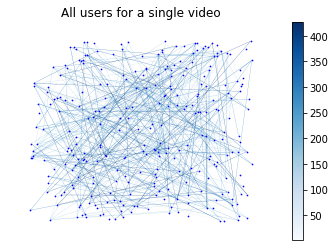

In [25]:
pos = nx.layout.random_layout(G)

node_sizes = 0.5
M = G.number_of_edges()
edge_colors = range(2, M + 2)
edge_alphas = [i / M  for i in range(M)]

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="blue")
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=0.3,
    edge_color=edge_colors,
    edge_cmap=plt.cm.Blues,
    # connectionstyle="arc3,rad=0.5",
    width=0.2,
)
# set alpha value for each edge
# for i in range(M):
#     edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(edge_colors)
plt.colorbar(pc)
ax = plt.gca()
ax.set_axis_off()
plt.title('All users for a single video')
plt.show()
